# Import dependencies

In [33]:
import csv
import pandas as pd
import os
import math
import re
import string
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import defaultdict

from youtube_transcript_api import YouTubeTranscriptApi

# Functions

## Generate singular subtitle

In [2]:
def generate_subtitles(video_id):
    try:
        video_subtitles = YouTubeTranscriptApi.get_transcript(video_id, languages=['en', 'en-US'])

        for subtitle in video_subtitles:
            subtitle['text'] = (subtitle['text'].replace('\n', ' ')).upper()
        
        return video_subtitles
    except Exception:
        print(f"Error occurred while processing video {video_id}, ID removed from the videos ID's list.")
        return None


## Generate all subtitles

In [3]:
def generate_all_subtitles(video_id_list):
    all_subtitles = []
 
    for VIDEO_ID in video_id_list:
        video_subtitles = generate_subtitles(VIDEO_ID)
        if video_subtitles is not None:
            all_subtitles.append((video_subtitles, VIDEO_ID))

    return all_subtitles

## Convert raw subtitles into CSV

In [4]:
def video_subtitles_into_csv(all_subtitles, VIDEO_DESTINATION_FOLDER):
    
    result_csv_filename = os.path.join(VIDEO_DESTINATION_FOLDER, 'VD_SUBTITLES.CSV')

    with open(result_csv_filename, 'w', newline='') as csvfile:
        fieldnames = ['text', 'start', 'duration', 'video_id']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        
        writer.writeheader()
        
        for subtitles, video_id in all_subtitles:
            for subtitle in subtitles:
                writer.writerow({'text': subtitle['text'], 'start': subtitle['start'], 'duration': subtitle['duration'], 'video_id': video_id})



## Build the stop words

In [5]:
def build_stop_words():
    # Words we don't want to be inserted into the histogram as valid words
    stop_words = ['a', 'an', 'and', 'are', 'as', 'at', 'be', 'but', 'by', 'for', 'if', 'in', 'into', 
    'is', 'it', 'no', 'not', 'of', 'on', 'or', 'such', 'that', 'the', 'their', 'then', 'these', 
    'they', 'this', 'to', 'was', 'will', 'with', 'i', "i'm", 'am', 'you',  "they're", 'your', 'out', 'my','...', '.']

    stop_words = [st_w.upper() for st_w in stop_words]
    
    return stop_words

In [6]:
def replace_stop_words(words):
    # Words we don't want to be inserted into the histogram as valid words
    stop_words = ['a', 'an', 'and', 'are', 'as', 'at', 'be', 'but', 'by', 'for', 'if', 'in', 'into', 
    'is', 'it', 'no', 'not', 'of', 'on', 'or', 'such', 'that', 'the', 'their', 'then', 'these', 
    'they', 'this', 'to', 'was', 'will', 'with', 'i', "i'm", 'am', 'you',  "they're", 'your', 'out', 'my',
    '...', '.', 'can', 'so', 'now', "you're", 'from', 'how', 'do', 'what', "then", "when", "where", "why", 
    "how", "who", "whom", "whose", "which", "what", "it's", 'me']

    stop_words = [st_w.upper() for st_w in stop_words]

    # Substituir todas as palavras na lista stop_words por 'stop word'
    new_words = ['Stop Words' if word in stop_words else word for word in words]
    
    return new_words

## Generate a list of all the videos histograms

In [7]:
def histogram_for_all():
    word_counts = defaultdict(int)
    video_counts = defaultdict(set)  # Conjunto para evitar a contagem duplicada de vídeos

    VIDEO_SUBTITLES_PATH = '.' + os.sep + 'VD_SUBTITLES.CSV'
    all_video_subtitles_df = pd.read_csv(VIDEO_SUBTITLES_PATH)    
    
    # Iterar sobre cada linha do DataFrame
    for index, row in all_video_subtitles_df.iterrows():
        # Dividir o texto em palavras e contar a frequência de cada palavra
       
        words = row['text'].split()
        words = replace_stop_words(words)
        
        word_set = set(words)  # Conjunto para contar cada palavra apenas uma vez por vídeo
        for word in word_set:
            word_counts[word] += 1
            video_counts[word].add(row['video_id'])

    # Converter os dicionários em listas de tuplas
    word_tuples = [(word, count) for word, count in word_counts.items()]
    video_tuples = [(word, len(videos)) for word, videos in video_counts.items()]

    # Criar DataFrames para as contagens de palavras e de vídeos
    df_word_counts = pd.DataFrame(word_tuples, columns=['Word', 'Word_Count'])
    df_video_counts = pd.DataFrame(video_tuples, columns=['Word', 'Video_Count'])

    # Mesclar os DataFrames em um único DataFrame
    df_combined = pd.merge(df_word_counts, df_video_counts, on='Word')

    return df_combined

## Get the destination folder acording to the video id

In [8]:
def get_destination_folder(video_id, YT_VIDEOS_FOLDER_PATH):
    folders = os.listdir(YT_VIDEOS_FOLDER_PATH)

    for sub_folder in folders:
        sub_folder_path = os.path.join(YT_VIDEOS_FOLDER_PATH, sub_folder)
        filenames = os.listdir(sub_folder_path)

        for filename in filenames:
            file_path = os.path.join(sub_folder_path, filename)

            if filename == "VD_INFO.CSV":
                with open(file_path, 'r', newline='') as csvfile:
                    reader = csv.DictReader(csvfile)
                    for row in reader:
                        if row['link_video'] == video_id:
                            return os.path.dirname(file_path) 

## Create the dataframe with most used words ocurrences and your phrases

In [9]:
def generate_words_ocurrence_dataframe(selected_words, video_subtitles, current_video_frame_rate):
    words_df = pd.DataFrame()

    for selected_word in selected_words:
        for sub in video_subtitles:

            text = sub['text'].split()

            if selected_word in text:
                start_time = sub['start']
                end_time = sub['start'] + sub['duration']
                text = sub['text']

                ini_frame = math.floor(start_time * current_video_frame_rate)
                end_frame = math.ceil(end_time * current_video_frame_rate)

                words_df = words_df._append({'selected_word': selected_word,
                                            'start_time_seconds': start_time,
                                            'end_time_seconds': end_time,
                                            'ini_frame': ini_frame,
                                            'end_frame': end_frame,
                                            'text': text},
                                        ignore_index=True)
    return words_df

## Get the current video frame rate

In [10]:
def get_video_frame_rate(VIDEO_DESTINATION_FOLDER, video_id):

    filenames = os.listdir(VIDEO_DESTINATION_FOLDER)

    for filename in filenames:
        file_path = os.path.join(VIDEO_DESTINATION_FOLDER, filename)

        if filename == "VD_INFO.CSV":
            with open(file_path, 'r', newline='') as csvfile:
                reader = csv.DictReader(csvfile)
                for row in reader:
                    if row['link_video'] == video_id:
                        return float(row['fps_vid']) 

## Get the selected lines 

In [11]:
def get_selected_measures(EXTRACTED_MEASURES_CSV_FILE_PATH, words_ocurrance_df):
    extracted_df = pd.read_csv(EXTRACTED_MEASURES_CSV_FILE_PATH)
    extracted_df = extracted_df.rename(columns={"Unnamed: 0": "frame_raw"})
    
    list_dataframe_croped = []

    for block_id, row in words_ocurrance_df.iterrows():
        ini_frame = row['ini_frame']
        end_frame = row['end_frame']

        croped_frames = extracted_df.query('frame_seq >= @ini_frame and frame_seq <= @end_frame')

        # Insert new columns at the left of the DataFrame
        croped_frames.insert(0, 'selected_word', row['selected_word'])
        croped_frames.insert(0, 'block_id', block_id)

        list_dataframe_croped.append(croped_frames)
    
    return list_dataframe_croped
        


## Get the videos id's

In [12]:
def get_videos_ids(YT_VIDEOS_LINK_LIST):
    video_ids = []
    with open(YT_VIDEOS_LINK_LIST, 'r') as file:
        for line in file:
            # Extract video ID from YouTube link using regular expression
            match = re.search(r'(?<=v=)[^&]+', line)
            if match:
                video_id = match.group(0)
                video_ids.append(video_id.strip())  # Remove leading and trailing whitespace
    return video_ids

In [13]:
# For 1 video

In [14]:
def single_video(video_id, group_df, YT_VIDEOS_FOLDER_PATH, selected_word_histogram):
    subtitles = []

    # Iterar sobre as linhas do DataFrame para este ID de vídeo
    for _, row in group_df.iterrows():
        # Criar um objeto para representar esta linha do DataFrame e adicioná-lo à lista
        video_object = {
            'text': row['text'],
            'start': row['start'],
            'duration': row['duration']
        }
        subtitles.append(video_object)

    VIDEO_DESTINATION_FOLDER = get_destination_folder(video_id, YT_VIDEOS_FOLDER_PATH)
    EXTRACTED_MEASURES_CSV_FILE_PATH = os.path.join(VIDEO_DESTINATION_FOLDER, "VD_MEASURE_L0.CSV") 
        
    current_video_frame_rate = get_video_frame_rate(VIDEO_DESTINATION_FOLDER, video_id)
            
    # Build the words ocurrance data frame
    words_occurrence_df = generate_words_ocurrence_dataframe(selected_word_histogram, subtitles, current_video_frame_rate)     

    # Save the histogram into a csv file
    words_occurrence_csv_filename = os.path.join(VIDEO_DESTINATION_FOLDER, "VD_WORDS_OCCURRENCE.CSV")
    words_occurrence_df.to_csv(words_occurrence_csv_filename, index=False)
        
    # Crop the extracted measures where the word occurred
    extracted_measures_selected_frames = get_selected_measures(EXTRACTED_MEASURES_CSV_FILE_PATH, words_occurrence_df)

    final_df = pd.DataFrame()

    # Concatenate all DataFrames into one
    for df in extracted_measures_selected_frames:
        final_df = pd.concat([final_df, df])

    final_dataframes_csv = os.path.join(VIDEO_DESTINATION_FOLDER, "VD_BLOCKS_WORDS_OCCURRENCE.CSV")
    final_df.to_csv(final_dataframes_csv, index=False)

    print("Process complete for video: " + video_id)

## Execute the functions for all videos

In [15]:
def histogram_words_ocurrence_each_video(selected_word_histogram):
    YT_VIDEOS_FOLDER_PATH = '.' + '.' + os.sep + 'Dataset' + os.sep + 'YT-Online' + os.sep

    VIDEO_SUBTITLES_PATH = '.' + os.sep + 'VD_SUBTITLES.CSV'
    all_video_subtitles_df = pd.read_csv(VIDEO_SUBTITLES_PATH) 

    for video_id, group_df in all_video_subtitles_df.groupby('video_id'):
        single_video(video_id, group_df, YT_VIDEOS_FOLDER_PATH, selected_word_histogram)

## Plot the column graph for the histogram

In [47]:
def plot_column_histogram_graph(df_combined_sorted, number_of_words):
    # Selecionar apenas as palavras mais frequentes
    top_words = df_combined_sorted.head(number_of_words[1])[1:15]

    # Atualizar configurações de fonte
    mpl.rcParams.update({
        'font.family': 'Times New Roman',  # Escolha o estilo de fonte desejado
        'font.size': 10,          # Tamanho da fonte em pontos
        'axes.labelsize': 'medium',  # Tamanho dos rótulos dos eixos
        'axes.titlesize': 'large',   # Tamanho dos títulos dos subplots
        'xtick.labelsize': 'small',  # Tamanho dos rótulos do eixo x
        'ytick.labelsize': 'small',  # Tamanho dos rótulos do eixo y
        'legend.fontsize': 'medium',  # Tamanho da fonte na legenda
        'figure.titlesize': 'large',  # Tamanho do título da figura
    })

    # Plotar o gráfico de barras
    plt.figure(figsize=(10, 6))
    bars = plt.bar(top_words['Word'], top_words['Word_Count'], color='skyblue')
    
    # Adicionar valor da amplitude acima de cada barra
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, height, str(int(height)), ha='center', va='bottom', rotation=45)

    plt.xlabel('Palavras')
    plt.ylabel('Número de Ocorrências')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('histogram.png')
    plt.show()


# Get the videos ID's

In [17]:
YT_SOURCE_LINKS_VIDEOS_FOLDER = '.' + '.' + os.sep + 'Video-Source' + os.sep + 'in_YT-List' + os.sep
YT_VIDEOS_LINK_LIST = os.path.join(YT_SOURCE_LINKS_VIDEOS_FOLDER, 'NEW_VIDEO_LIST.LST')

# Get the videos ID's
videos_ids_list = get_videos_ids(YT_VIDEOS_LINK_LIST)

print(videos_ids_list)

['gwIcgyqioPo', 'CwjV6MDU9E8', 'oa1QJL7tv4g', 'mE45MLeTUOw', '_uiqV7p3fwM', 'wexzvClUcUk', 'tt4TF1wqz9U', 'DSaj9qMwvLI', 'yKCUTZaKgNA', 'OUAWJRALAzQ', 'LOS5WB75gkY', '05SLQsbY310', 'e6ME0UGNwNQ', 'aRs0k5pPXQo', '9cg3wsfoU40', 'qNrJbE0U5fg', 'nxFUViPHEnc', 'Y5q2CaJxVXg', '591eurlufSo', 'LeXArY1x9zo', 'ec_OJbZ4ByQ', 'hqHWFrG1my8', 'R-oBT97ujqQ', '1kEXoDqDMMA', '2vwi5y5UKgk', 'gbegsiuprlA', 'ojbMAVRG_o4', 'X9WfTOwx05g', 'utwNhk3nmVU', 'LrjlW00kkws', 'HgVBxs5G1zE', 'pzCuKh7QyOA', 'J8JCvKDqkj8', 'H7GYeKu9L_8', 'w69hIDMXSaw', '2HkUPY2eo4E', 'fL1WMdft3OE', 'zAvkbjxA7UY', 'Azp4Wd8Vb8E', '2ftkADtZKAc', 'o-IMRj3ajPY']


# Generate the subtitles

In [18]:
# Select the amount of videos: [:1] / [:5] / [:10]
videos_ids_list_selected = videos_ids_list[:]

all_subtitles = generate_all_subtitles(videos_ids_list_selected)

Error occurred while processing video OUAWJRALAzQ, ID removed from the videos ID's list.
Error occurred while processing video 591eurlufSo, ID removed from the videos ID's list.
Error occurred while processing video ec_OJbZ4ByQ, ID removed from the videos ID's list.
Error occurred while processing video R-oBT97ujqQ, ID removed from the videos ID's list.
Error occurred while processing video 2vwi5y5UKgk, ID removed from the videos ID's list.
Error occurred while processing video X9WfTOwx05g, ID removed from the videos ID's list.
Error occurred while processing video fL1WMdft3OE, ID removed from the videos ID's list.
Error occurred while processing video zAvkbjxA7UY, ID removed from the videos ID's list.
Error occurred while processing video Azp4Wd8Vb8E, ID removed from the videos ID's list.
Error occurred while processing video 2ftkADtZKAc, ID removed from the videos ID's list.
Error occurred while processing video o-IMRj3ajPY, ID removed from the videos ID's list.


## Save subtitles into CSV

In [19]:
# Save all subtitles into CSV
video_subtitles_into_csv(all_subtitles, '.')

# Generate the histogram

In [20]:
# Generate the final histogram
final_histogram_df = histogram_for_all()

# Sort the final histogram
final_histogram_df_sorted = final_histogram_df.sort_values(by='Word_Count', ascending=False)

final_histogram_df_sorted.to_csv('histograms.csv')

# Plot the histogram

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

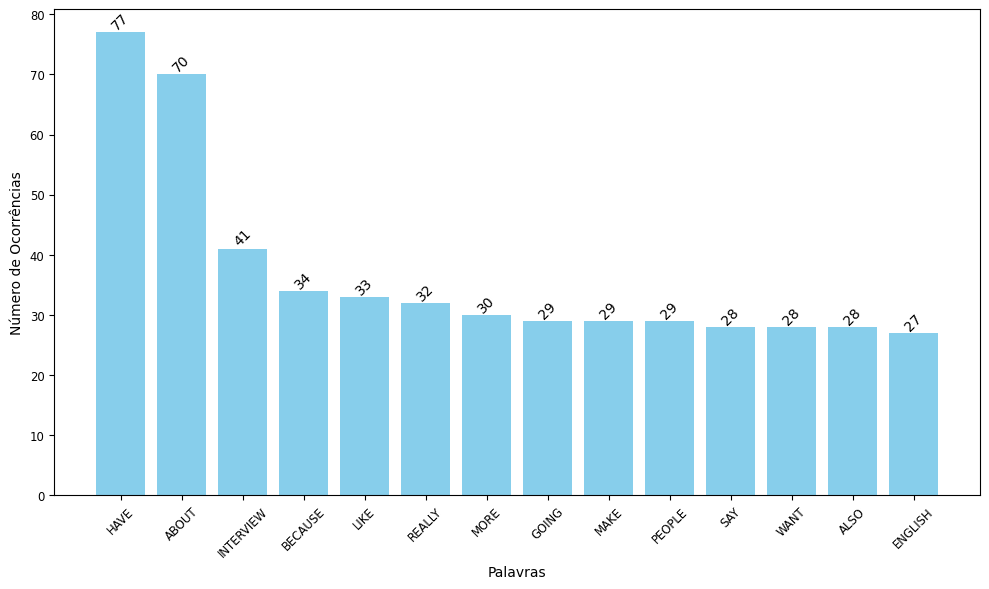

In [48]:
# Plot the [ini, end] most frequent words into columns
plot_column_histogram_graph(final_histogram_df_sorted, [1, 15])

# Execute the code for selected videos

In [22]:
# Get ten most frequent word in the histogram
most_frequent_words = final_histogram_df_sorted.head(10)['Word'].tolist()

# Choosing manually the words
most_frequent_words = ['PRESENTATION', 'HAVE', 'ABOUT', 'INTERVIEW']

# Get the occurrence of each selected_word from the histogram on every video
histogram_words_ocurrence_each_video(most_frequent_words)

Process complete for video: 05SLQsbY310
Process complete for video: 1kEXoDqDMMA
Process complete for video: 2HkUPY2eo4E
Process complete for video: 9cg3wsfoU40
Process complete for video: CwjV6MDU9E8
Process complete for video: DSaj9qMwvLI
Process complete for video: H7GYeKu9L_8
Process complete for video: HgVBxs5G1zE
Process complete for video: J8JCvKDqkj8
Process complete for video: LOS5WB75gkY
Process complete for video: LeXArY1x9zo
Process complete for video: LrjlW00kkws
Process complete for video: Y5q2CaJxVXg
Process complete for video: _uiqV7p3fwM
Process complete for video: aRs0k5pPXQo
Process complete for video: e6ME0UGNwNQ
Process complete for video: gbegsiuprlA
Process complete for video: gwIcgyqioPo
Process complete for video: hqHWFrG1my8
Process complete for video: mE45MLeTUOw
Process complete for video: nxFUViPHEnc
Process complete for video: oa1QJL7tv4g
Process complete for video: ojbMAVRG_o4
Process complete for video: pzCuKh7QyOA
Process complete for video: qNrJbE0U5fg


In [23]:
#<end